In [6]:
import pandas
import os
import sys
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting
import umap
import plotly
sys.path.insert(0,'/home/users/jvogel/git/hack_projects/')
import label_coordinate as lc

In [89]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
bigdf = bigdf.values

In [5]:
rix = np.random.permutation(list(range(bigdf.shape[-1])))[:1000]
pca_mod = PCA(n_components=100).fit(bigdf[:,rix].T)
print('explained variances:', sum(pca_mod.explained_variance_ratio_))
tfm_mtx = pca_mod.transform(bigdf.T)

explained variances: 0.801864368665


In [6]:
del(bigdf)

In [14]:
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
outdir = os.path.join(os.getcwd(),'umap_output')
nbrs = list(range(5,55,5))
dists = [0.001,0.01,0.1,0.5]
labs = [0 if gdf.loc[x,'slab_type'] == 'CX' else 1 if gdf.loc[x,'slab_type'] == 'BS' else 2 for x in gdf.index]

In [ ]:
gdf = pandas.read_csv(os.path.join(wdir,'gxp_correlation_wholebrain_results_NEW.csv'))
outdir = os.path.join(os.getcwd(),'umap_output')
nbrs = list(range(5,55,5))
dists = [0.001,0.01,0.1,0.5]
labs = [0 if gdf.loc[x,'slab_type'] == 'CX' else 1 if gdf.loc[x,'slab_type'] == 'BS' else 2 for x in gdf.index]
for nbr in nbrs:
    for dist in dists:
        print('working on nbr=%s, dist=%s'%(nbr,dist))
        embedding = umap.UMAP(n_components=3, n_neighbors=nbr, min_dist=dist).fit_transform(tfm_mtx)
        plt.close()
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c = np.array(labs), cmap='Spectral', s=5)
        plt.savefig(os.path.join(outdir,'umap_%s_%s.pdf'%(nbr,dist)))

In [ ]:
new_map = dict(zip(np.unique(labs),range(len(np.unique(labs)))))
newlabs = [new_map[x] for x in results.Label.values]
for nbr in nbrs:
    for dist in dists:
        print('working on nbr=%s, dist=%s'%(nbr,dist))
        embedding = umap.UMAP(n_components=3, n_neighbors=nbr, min_dist=dist).fit_transform(tfm_mtx)
        plt.close()
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c = newlabs, cmap='Spectral', s=5)
        plt.savefig(os.path.join(outdir,'dkt_umap_%s_%s.pdf'%(nbr,dist)))

### And then Alex arrived and we did Plotly together

In [16]:
plt.cm.tab10.colors[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [18]:
nbr = 25
dist = 0.5
embedding = umap.UMAP(n_components=3, n_neighbors=nbr, min_dist=dist).fit_transform(tfm_mtx)

In [19]:
embedding.shape

(3702, 3)

In [23]:
lmap = dict(zip(np.unique(labs),gdf.slab_type.unique()))
lmap

{0: 'CX', 1: 'BS', 2: 'CB'}

In [ ]:
nbr = 25
dist = 0.5
embedding = umap.UMAP(n_components=3, n_neighbors=nbr, min_dist=dist).fit_transform(tfm_mtx)

In [92]:
for i in range(3):
    print('rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab10(i) if x > 0])))

rgba (0.12156852745098039, 0.46666656666666667, 0.70588225294117657, 0.99999990000000005)
rgba (0.99999990000000005, 0.49803911568627451, 0.054901860784313722, 0.99999990000000005)
rgba (0.17254891960784313, 0.62745088039215691, 0.17254891960784313, 0.99999990000000005)


In [94]:
lmap = dict(zip(np.unique(labs),gdf.slab_type.unique()))
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab10(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=2,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='test.html')
    

'file:///home/users/jvogel/git/hack_projects/test.html'

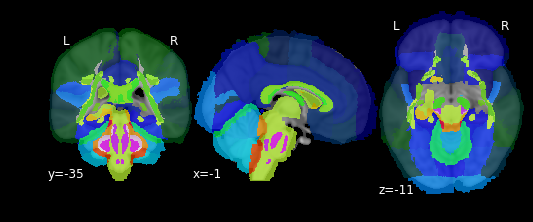

In [44]:
mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
all_labs = ni.load('/home/users/jvogel/Science/templates/atlases/full_brain_atlas.nii.gz')
plt.close()
plotting.plot_roi(all_labs, 
                  mni, draw_cross=False)
plt.show()


In [47]:
lc.label_coordinate_by_atlas?

In [48]:
gdf.columns [-5:]

Index(['gabe_label', 'mni_nlin_x', 'mni_nlin_y', 'mni_nlin_z',
       'AP_axis_gxp_signature_similarity_SPCR'],
      dtype='object')

In [50]:
from importlib import reload
reload(lc)

<module 'label_coordinate' from '/home/users/jvogel/git/hack_projects/label_coordinate.py'>

In [52]:
newlabs = lc.label_coordinate_by_atlas(all_labs, gdf[gdf.columns[-4:-1]],cube_size=3)

checking and initializing inputs
extracting labels
completed
65 coordinates were outside of the provided atlas


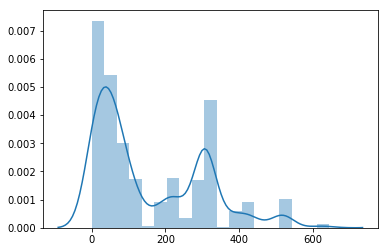

In [53]:
plt.close()
sns.distplot(newlabs)
plt.show()

In [74]:
np.random.permutation(range(len(np.unique(newlabs))))

array([ 34,  41, 173, 125,  65,  30, 151, 154,  53, 159, 106, 200, 205,
       128,  56,   2, 188,  11, 165, 113, 163, 138, 101, 153,  93,  33,
       112,  50,  92,  95,  97, 177, 118,  47,  64,  55,  21,  49,  20,
        43,  37, 115, 164,  94,  68, 121,  42,  13,  16, 195, 190,  78,
       178,  46, 140, 148,  36, 149, 182, 161,  98, 206, 142, 193,  60,
       131,  14, 194, 134, 117,  66, 172, 108,  62, 156,  48, 183, 202,
        59,  86,  67,  51, 110, 209, 100,  27, 158, 124, 180,  44,   8,
       187,  90, 119, 162,  74,  23,   9, 146,  58,  76, 133, 109, 155,
        39,  18,  52,   0, 181, 103,  87,  96, 144, 104, 135,  77, 132,
       212,  29, 102,  15,  84, 141, 136,  28, 167, 179, 199, 111, 198,
        26, 160,  85,  63,  72, 145,  61, 152,   4,  73, 208, 210, 169,
        70,  54,  38,  81, 176, 123, 207, 122, 192,   7, 127,  40, 201,
        71,  45, 175, 129, 168,  57, 137, 157, 120, 197, 174, 184,  89,
       186, 204, 150,  12, 147,  91,  75, 107,  69,  35,  80,  8

In [75]:
lmap = dict(zip(np.unique(newlabs), np.random.permutation(range(len(np.unique(newlabs))))))

In [76]:
mapped_labs = [lmap[x] for x in newlabs.Label]
#mapped_labs

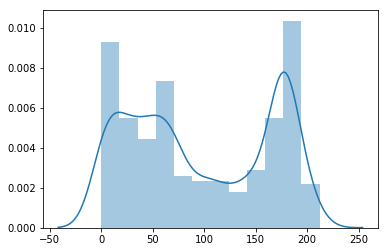

In [60]:
plt.close()
sns.distplot(mapped_labs)
plt.show()

In [78]:
plt.cm.gist_ncar(250)

(0.98214382929642441, 0.8816695501730103, 0.98418150711264896, 1.0)

In [97]:
traces = list()
for lab in np.unique(mapped_labs):
    l_index = [x for x in range(len(mapped_labs)) if mapped_labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.gist_ncar(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = str(lab),
                                            mode = 'markers',
                                            marker = dict(size=2,
                                                          color=color_str,
                                                          line = dict(color = color_str,
                                                                     width = 2)
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='test.html')
    

'file:///home/users/jvogel/git/hack_projects/test.html'

In [89]:
for i in range(len(np.unique(mapped_labs))):
    print(i,'rgba %s'%str(plt.cm.prism(i)))


0 rgba (1.0, 0.0, -0.0, 1.0)
1 rgba (1.0, 0.0, 0.0, 1.0)
2 rgba (1.0, 0.1296454183688629, 0.0, 1.0)
3 rgba (1.0, 0.32029829327221621, 0.0, 1.0)
4 rgba (1.0, 0.51159084306619762, 0.0, 1.0)
5 rgba (1.0, 0.6909103343111338, 0.0, 1.0)
6 rgba (1.0, 0.84643346836812827, 0.0, 1.0)
7 rgba (1.0, 0.96790594189041745, 0.0, 1.0)
8 rgba (0.88898421888398071, 1.0, 0.0, 1.0)
9 rgba (0.69909862663780242, 1.0, 0.0, 1.0)
10 rgba (0.50729443786688511, 1.0, 0.0, 1.0)
11 rgba (0.3262181205501743, 0.99656884067734919, 0.0, 1.0)
12 rgba (0.1678088083602195, 0.88704937576431875, 0.0, 1.0)
13 rgba (0.042511102674156365, 0.74080127036414689, 0.22472455928829391, 1.0)
14 rgba (0.0, 0.56746728563745519, 0.49152494140092684, 1.0)
15 rgba (0.0, 0.37847607025743346, 0.72591698836659457, 1.0)
16 rgba (0.0, 0.18628862087343018, 0.91244623312977824, 1.0)
17 rgba (0.0, 0.0035766754707545201, 1.0, 1.0)
18 rgba (0.10014583563595647, 0.0, 1.0, 1.0)
19 rgba (0.24310366462004168, 0.0, 1.0, 1.0)
20 rgba (0.41420858919315884, 

In [99]:
min(gdf.mni_nlin_x)

-70.604856909036499

In [114]:
nx = list()
ny = list()
nz = list()
for k,col in enumerate(gdf.columns[-4:-1]):
    for i in gdf.index:
            val = gdf.loc[i,col]
            nval = (val + abs(min(gdf[col]))) / (max(gdf[col]) + abs(min(gdf[col])))
            if k == 0:
                nx.append(nval)
            elif k == 1:
                ny.append(nval)
            else:
                nz.append(nval)


In [115]:
for lst in [nx,ny,nz]:
    print(min(lst),max(lst))

0.0 1.0
0.0 1.0
0.0 1.0


In [142]:
rgb_labs_py = ['rgba %s'%str(tuple([nx[x],ny[x],nz[x],0.4])) for x in range(len(nx))]
rgb_labs_np = [tuple([nx[x],ny[x],nz[x],0.4]) for x in range(len(nx))]

In [175]:
xyz_labs_py = ['%s, %s, %s'%(gdf.mni_nlin_x[x],
                           gdf.mni_nlin_y[x],
                           gdf.mni_nlin_z[x]) for x in range(len(nx))]
xyz_labs_py

['-30.5566818812, 4.81520741048, -3.82596053563',
 '-11.9595264271, 4.81238071869, -9.90802593075',
 '9.52511112195, 6.20609820747, -10.3308649175',
 '8.037895645, -0.206559448214, -9.481506815',
 '17.4590304093, -0.798126192616, -12.1568978939',
 '36.8588410701, -2.42992020618, 3.69276607029',
 '13.8104878468, 0.803284801628, -1.81860037447',
 '27.0224335321, -0.020683920053, -24.8692276111',
 '20.3339070749, -1.05237578868, -18.0118565234',
 '19.8040497208, -0.204885552935, -25.5260434893',
 '22.0136090654, -0.105416640823, -22.9524101014',
 '-10.839895433, 1.07681257352, -10.9120432763',
 '0.0350655194986, 3.06406683029, 2.83600659246',
 '1.18054033206, 3.9813720227, 5.29574293845',
 '-14.2405037614, 2.12354497314, -3.49886876788',
 '-34.6336222182, -2.20226485435, 1.20877170427',
 '30.5884065569, -17.811238257, 7.69321114898',
 '-33.2837927458, -16.8828692936, 1.98061030155',
 '-2.48547735171, -6.12381920613, 18.5453493946',
 '21.876385444, -42.3632596225, 4.71040157448',
 '23.8991

In [ ]:
traces = list()
for lab in np.unique(mapped_labs):
    l_index = [x for x in range(len(mapped_labs)) if mapped_labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.gist_ncar(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = str(lab),
                                            mode = 'markers',
                                            marker = dict(size=2,
                                                          color=color_str,
                                                          line = dict(color = color_str,
                                                                     width = 2)
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='test.html')
    

In [130]:
plotly.graph_objs.Scatter3d?

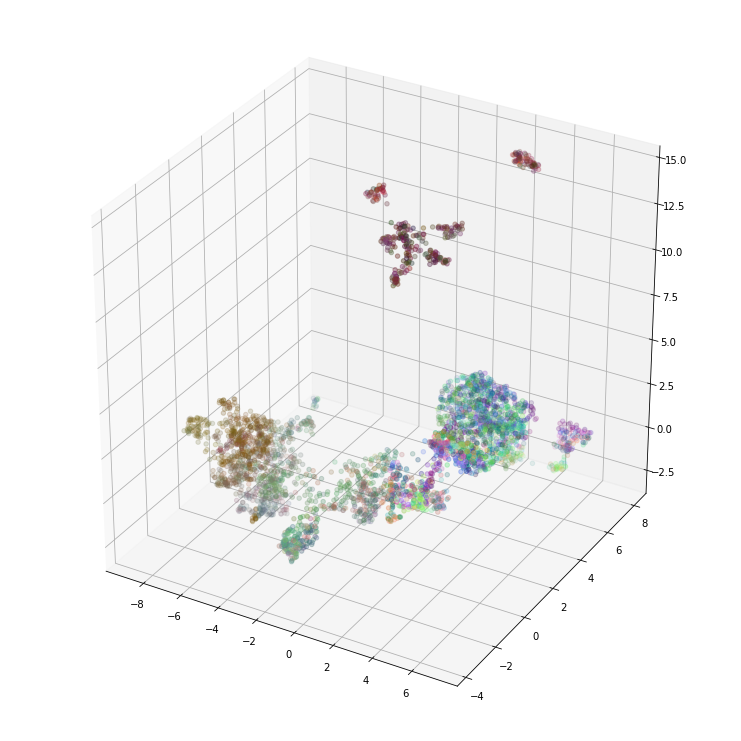

In [144]:
plt.close()
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c = rgb_labs_np, s=20)
plt.show()
#plt.savefig(os.path.join(outdir,'umap_%s_%s.pdf'%(nbr,dist)))

In [161]:
# from sklearn.mixture import BayesianGaussianMixture
# BayesianGaussianMixture?

In [179]:
plotly.graph_objs.Scatter3d

In [178]:
temp_trace = plotly.graph_objs.Scatter3d(x=embedding[:,0],
                                        y = embedding[:,1],
                                        z = embedding[:,2],
                                        name = str(lab),
                                        mode = 'markers',
                                        marker = {'size': 2, 
                                                  'color': list(range(len(rgb_labs_py))), 
                                                  'colorscale':rgb_labs_py},
                                        #hovertext = xyz_labs_py
                                        hovertext = gdf.structure_name.values)


layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=[temp_trace], layout=layout)
plotly.offline.plot(fig, filename='test.html')


'file:///home/users/jvogel/git/hack_projects/test.html'

## Spectral Embedding

In [ ]:
se_mod = SpectralEmbedding(n_components=3, n_jobs=-1).fit(bigdf.T)
tfm_mtx = se_mod.fit_transform(bigdf.T)
tfm_mtx.shape

In [ ]:
c = gd

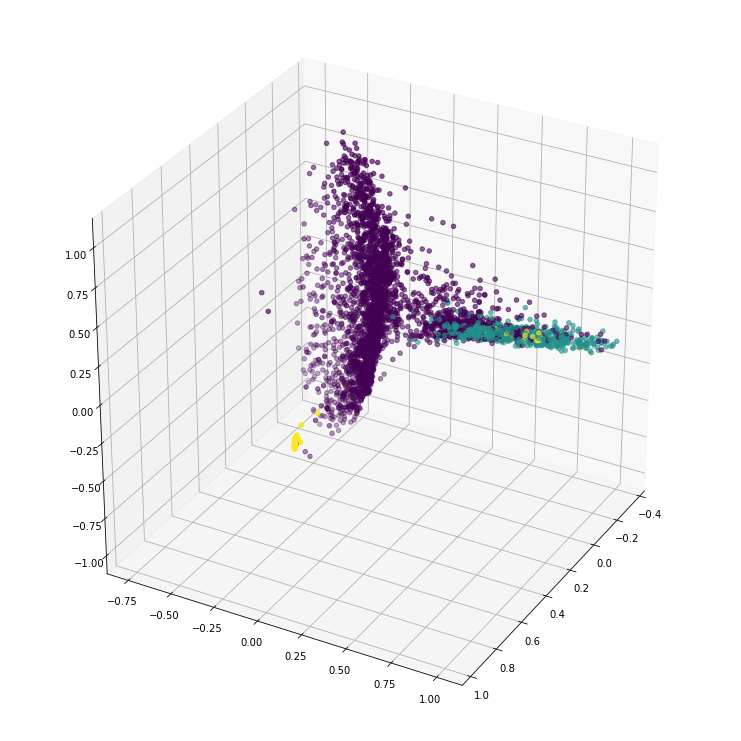

In [15]:
plt.close()
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(tfm_mtx[:,0], tfm_mtx[:,1], tfm_mtx[:,2], s=20, c = labs)
# , c = rgb_labs_np
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
plt.show()
#plt.savefig(os.path.join(outdir,'umap_%s_%s.pdf'%(nbr,dist)))

In [20]:
del(bigdf)

In [36]:
hdf = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_hippocampus_gxp.csv',
                     index_col = 0)
hdf.head()

,10021_20,10021_21,10021_22,10021_23,10021_24,10021_525,10021_526,10021_527,10021_528,10021_529,...,9861_789,9861_791,9861_793,9861_797,9861_798,9861_799,9861_804,9861_805,9861_806,9861_807
0,-0.075680,0.687474,0.435731,-0.528432,0.151001,0.480406,0.660119,0.635282,-0.950707,-1.794701,...,-0.854386,-1.298184,-0.314338,-1.405429,-0.986159,-0.539705,0.310073,-0.185890,-0.760153,-1.156494
1,-0.105828,-0.080013,0.938624,0.340545,0.196417,-0.281919,-0.281919,-0.281919,-0.146346,-0.122736,...,-0.279874,-0.322989,-0.076614,-0.307653,-0.166291,-0.142514,-0.330683,-0.311726,0.071945,-0.190493
2,-0.124526,-0.101640,0.038588,0.044294,-0.304078,-0.337035,-0.274058,-0.337035,-0.128501,-0.064542,...,-0.088185,-0.329613,0.025157,-0.225742,-0.055409,-0.008256,-0.348750,-0.348750,-0.149676,0.042965
3,0.500797,0.369799,0.648277,-0.136394,-0.397970,-0.074482,-0.354070,0.290655,0.214679,0.156800,...,0.615837,1.837306,-0.399442,1.045389,1.043883,0.028797,0.890627,0.785455,-0.474766,0.043116
4,0.360384,-0.108787,0.579915,0.369534,0.009912,-0.048502,-0.070200,0.088653,0.062610,0.046749,...,1.111220,1.301074,0.367464,0.794877,0.685466,1.286411,0.407277,0.424040,0.685054,1.715385


In [21]:
tfm_mtx = SpectralEmbedding(n_components=3, n_jobs=-1).fit_transform(hdf.T)
tfm_mtx.shape

(170, 3)

In [26]:
href = pandas.read_csv(
        '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_hippocampus_sample_info.csv')
smap = dict(zip(href.structure_acronym.unique(),range(len(href.structure_acronym.unique()))))
hlabs = [smap[x] for x in href.structure_acronym]

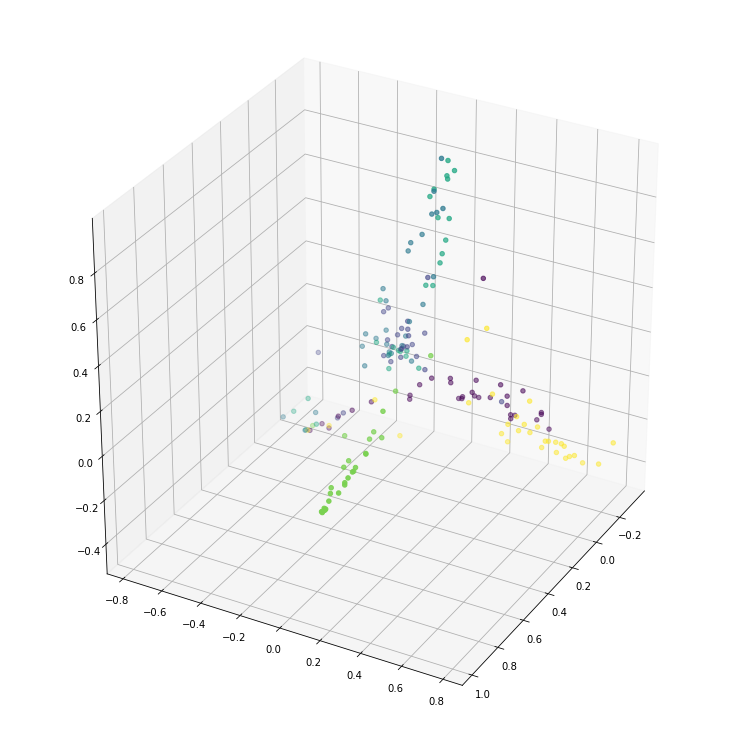

In [27]:
plt.close()
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(tfm_mtx[:,0], tfm_mtx[:,1], tfm_mtx[:,2], s=20, c = hlabs)
# , c = rgb_labs_np
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
plt.show()
#plt.savefig(os.path.join(outdir,'umap_%s_%s.pdf'%(nbr,dist)))

In [32]:
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import train_test_split

In [39]:
#hdf = hdf.T
hdf_cols = hdf.index
hdf.index = range(len(hdf.index))
tr,te = train_test_split(hdf)


,0,1,2,3,4,5,6,7,8,9,...,58682,58683,58684,58685,58686,58687,58688,58689,58690,58691
0,-0.075680,-0.105828,-0.124526,0.500797,0.360384,-0.207167,-0.514421,-0.244761,0.185885,-2.564161,...,-1.884196,-1.670298,-0.205812,0.283161,-0.185807,-0.174138,-1.675717,-0.599723,0.122416,0.475176
1,0.687474,-0.080013,-0.101640,0.369799,-0.108787,0.392938,-0.616942,0.190240,1.680781,-0.584782,...,-0.787994,-0.792112,0.194304,-1.310554,-1.052466,-0.141409,0.005101,-0.557286,-0.770416,1.724339
2,0.435731,0.938624,0.038588,0.648277,0.579915,-0.178781,-0.739520,-0.276820,2.194807,-1.185124,...,-1.469652,-2.660932,-0.101291,-1.295971,-1.133388,-0.157742,-1.226904,-0.262520,0.484076,0.581272
3,-0.528432,0.340545,0.044294,-0.136394,0.369534,0.098495,-0.466517,-0.672807,2.291231,-1.677381,...,-0.759044,-0.797274,0.194297,-0.129874,-0.864190,-0.192984,0.040840,-0.421550,0.819940,1.083380
4,0.151001,0.196417,-0.304078,-0.397970,0.009912,-0.052840,-1.236222,0.648321,2.139745,-2.674234,...,0.023974,0.002965,-0.447656,0.461922,-0.967511,1.051998,-0.608400,-0.834933,0.684257,0.117195
5,0.480406,-0.281919,-0.337035,-0.074482,-0.048502,-0.155371,0.064375,0.166424,1.394699,-0.960175,...,0.198008,0.361325,-0.311134,1.294754,1.788741,2.135654,-0.749028,0.373102,0.290111,-1.035401
6,0.660119,-0.281919,-0.274058,-0.354070,-0.070200,-0.197029,0.878022,-0.922824,0.700107,-1.758806,...,-1.446253,-0.557416,0.844371,0.102251,0.391136,-0.131547,-0.477086,1.113187,1.386693,0.067536
7,0.635282,-0.281919,-0.337035,0.290655,0.088653,-0.168698,0.753579,0.074879,-0.004010,-0.218154,...,-2.159217,-0.721175,-0.515158,0.001551,0.203526,0.136642,-0.753604,-0.244327,-0.105558,0.309370
8,-0.950707,-0.146346,-0.128501,0.214679,0.062610,-0.196179,1.320993,0.065429,0.048313,-1.975910,...,-2.488444,-0.267672,-0.311073,-0.193794,1.371317,-0.105886,-0.795948,-0.834933,-0.235004,0.678951
9,-1.794701,-0.122736,-0.064542,0.156800,0.046749,-0.447604,0.991550,-0.051718,-0.269947,0.037338,...,-1.437517,-0.622768,-0.270486,0.681986,0.941698,-0.100029,-0.658034,-0.045479,0.847569,0.600026


In [61]:
tr_y = href.loc[tr.index,['mni_nlin_y','mni_nlin_z']]
te_y = href.loc[te.index,['mni_nlin_y','mni_nlin_z']]

In [62]:
cca_mod = CCA()
cca_mod.fit(tr,tr_y)

CCA(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

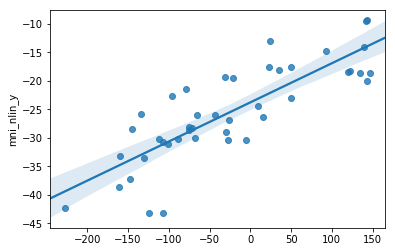

(0.82715249085920162, 8.1141500090731904e-12)


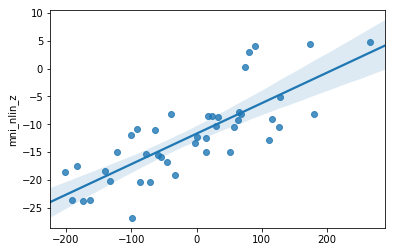

(0.79461062745405775, 2.0010913257078015e-10)


In [66]:
for i in range(2):
    plt.close()
    sns.regplot(cca_mod.predict(te)[:,i],te_y.loc[:,te_y.columns[i]])
    plt.show()
    print(stats.pearsonr(cca_mod.predict(te)[:,i],te_y.loc[:,te_y.columns[i]]))

In [88]:
probes = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/normalized_microarray_donor10021/Probes.csv')
jnk = pandas.DataFrame(cca_mod.x_loadings_)
jnk.loc[:,'abs_y'] = [round(abs(x),5) for x in jnk.loc[:,0]]
jnk.loc[:,'abs_z'] = [round(abs(x),5) for x in jnk.loc[:,1]]
jnk.loc[:,'abs_combined'] = jnk.abs_y + jnk.abs_z
jnk.loc[:,'gene_symbol'] = probes.loc[:,'gene_symbol']
jnk.loc[:,'gene_name'] = probes.loc[:,'gene_name']
jnk.sort_values('abs_combined',ascending=False)[:50]

,0,1,abs_y,abs_z,abs_combined,gene_symbol,gene_name
53423,-0.020573,-0.030185,0.02057,0.03019,0.05076,A_32_P50187,AGILENT probe A_32_P50187 (non-RefSeq)
14245,0.028936,0.019305,0.02894,0.01931,0.04825,SYTL2,synaptotagmin-like 2
43820,-0.021149,-0.026274,0.02115,0.02627,0.04742,RP11-291L15.2,HHIP antisense RNA 1 (non-protein coding)
40112,0.032927,0.014412,0.03293,0.01441,0.04734,NR2F2,"nuclear receptor subfamily 2, group F, member 2"
47751,-0.018731,-0.028374,0.01873,0.02837,0.04710,A_23_P395670,AGILENT probe A_23_P395670 (non-RefSeq)
24685,0.029898,0.016621,0.02990,0.01662,0.04652,PYDC1,PYD (pyrin domain) containing 1
16389,-0.023361,-0.022674,0.02336,0.02267,0.04603,HHIP,hedgehog interacting protein
53734,0.022680,0.022835,0.02268,0.02284,0.04552,C1orf187,chromosome 1 open reading frame 187
16390,-0.023025,-0.022420,0.02303,0.02242,0.04545,HHIP,hedgehog interacting protein
35503,0.030207,0.014850,0.03021,0.01485,0.04506,NR2F2,"nuclear receptor subfamily 2, group F, member 2"


In [64]:
cca_mod.score(te,te_y)

-152.77391705787645

In [65]:
cca_mod.score?

In [95]:
bigdf = pandas.DataFrame(bigdf.T)
tr,te = train_test_split(bigdf)
tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z']]
te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z']]
cca_mod = CCA()
cca_mod.fit(tr,tr_y)

CCA(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

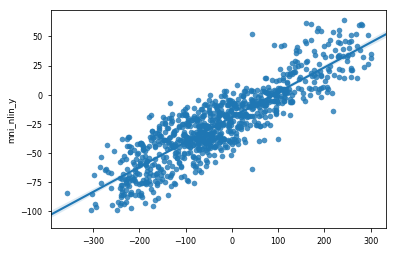

(0.87749588924438804, 3.9328104395246765e-297)


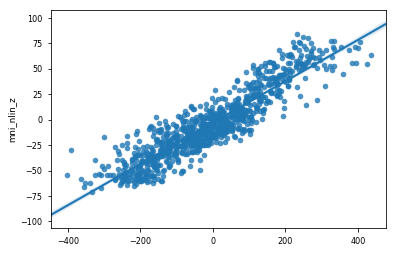

(0.91125680996821401, 0.0)


In [97]:
sns.set_context('paper')
for i in range(2):
    plt.close()
    sns.regplot(cca_mod.predict(te)[:,i],te_y.loc[:,te_y.columns[i]])
    plt.show()
    print(stats.pearsonr(cca_mod.predict(te)[:,i],te_y.loc[:,te_y.columns[i]]))

In [99]:
cca_mod.x_rotations_.shape

(58692, 2)

In [100]:
cca_mod.x_loadings_.shape

(58692, 2)

In [101]:
cca_mod.x_weights_.shape

(58692, 2)

In [102]:
cca_mod.x_weights_[:5]

array([[ -4.35568460e-03,   1.65106599e-02],
       [  9.41757349e-03,  -1.16070846e-02],
       [  2.89107978e-03,  -5.14931503e-03],
       [ -3.19449833e-03,  -2.17120148e-05],
       [ -2.08825892e-03,  -5.95771131e-04]])

In [103]:
cca_mod.x_rotations_[:5]

array([[-0.00435568,  0.01524453],
       [ 0.00941757, -0.00886955],
       [ 0.00289108, -0.00430893],
       [-0.0031945 , -0.0009503 ],
       [-0.00208826, -0.00120279]])

In [104]:
cca_mod.x_loadings_[:5]

array([[ 0.01976209, -0.01634899],
       [-0.00726957, -0.0020395 ],
       [-0.02019739,  0.02050197],
       [ 0.03562238, -0.00027852],
       [ 0.027334  ,  0.03790668]])

In [106]:
stats.pearsonr(cca_mod.x_loadings_[0,:],
              cca_mod.x_weights_[0,:])

(-1.0, 0.0)

In [107]:
stats.pearsonr(cca_mod.x_loadings_[0,:],
              cca_mod.x_rotations_[0,:])

(-1.0, 0.0)

In [108]:
from sklearn import linear_model

In [110]:
linear_model.MultiTaskLassoCV?

In [111]:
#probes = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/normalized_microarray_donor10021/Probes.csv')
jnk = pandas.DataFrame(cca_mod.x_loadings_)
jnk.loc[:,'abs_y'] = [round(abs(x),5) for x in jnk.loc[:,0]]
jnk.loc[:,'abs_z'] = [round(abs(x),5) for x in jnk.loc[:,1]]
jnk.loc[:,'abs_combined'] = jnk.abs_y + jnk.abs_z
jnk.loc[:,'gene_symbol'] = probes.loc[:,'gene_symbol']
jnk.loc[:,'gene_name'] = probes.loc[:,'gene_name']
jnk.sort_values('abs_combined',ascending=False)[:50]

,0,1,abs_y,abs_z,abs_combined,gene_symbol,gene_name
6453,0.102009,-0.100787,0.10201,0.10079,0.20280,NR2E1,"nuclear receptor subfamily 2, group E, member 1"
611,-0.095870,0.104457,0.09587,0.10446,0.20033,DAO,D-amino-acid oxidase
6452,0.101406,-0.091326,0.10141,0.09133,0.19274,NR2E1,"nuclear receptor subfamily 2, group E, member 1"
612,-0.087119,0.104179,0.08712,0.10418,0.19130,DAO,D-amino-acid oxidase
33403,0.093551,-0.097580,0.09355,0.09758,0.19113,EMX2OS,EMX2 opposite strand/antisense RNA (non-protei...
56559,0.082561,-0.107430,0.08256,0.10743,0.18999,A_32_P85405,AGILENT probe A_32_P85405 (non-RefSeq)
10340,-0.081284,0.108708,0.08128,0.10871,0.18999,STON1,stonin 1
1478,0.093397,-0.096509,0.09340,0.09651,0.18991,EMX2,empty spiracles homeobox 2
50573,-0.090697,0.097052,0.09070,0.09705,0.18775,A_24_P715719,AGILENT probe A_24_P715719 (non-RefSeq)
43743,0.100973,-0.086128,0.10097,0.08613,0.18710,RP1-163G9.1,uncharacterized LOC440556
